We wanted to check whether network subsets preserve the properties of their networks by subsetting either edges or nodes. To do this we take 3 unweighted "parent" networks and subset them: 
- 1) a real world example (Lewis Lab github repository - Human-2020-Hou-LR-pairs.csv - https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs)
- 2) a random scale-free bipartite network 
- 3) a normally distributed bipartite network generated by networkx

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import igraph
from tqdm import tqdm
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import sys
sys.path.insert(1, '../../../scripts')
from simulation.graphs import graph_generator
gg = graph_generator()

# Generate Parent Networks

In [2]:
# Parent Network 1
# load csv
hou = pd.read_excel('/data2/hratch/cci_dt/Ligand-Receptor-Pairs/Human/Human-2020-Hou-LR-pairs.xlsx')
G1 = nx.from_edgelist(list(zip(hou['Ligand gene symbol'], hou['Receptor gene symbol'])))

# # get properties for other parent networks
# G2 = Simulate().emulate_sf_network(G1)

# G3 = nx.bipartite.random_graph(len(set(hou['Ligand gene symbol']).intersection(G1.nodes)),
#                                len(set(hou['Receptor gene symbol']).intersection(G1.nodes)), p = 0.7)

In [3]:
G = G1.copy()

# Subset Nodes

In [4]:
# # lazy coding but gets the job done
# res = gg.summarize(G).T
# for col in ['subset_size', 'n_nodes_dropped', 'true_subset_size']:
#     res[col] = float('nan')


# n_iter = 1000
# n_core = 20
# for subset_size in tqdm([0.05,0.2,0.4,0.6,0.8]):
#     def get_summary(i):
#         try:
#             G2 = gg.subset_nodes(G, subset_size = subset_size, drop = False)
#             n0 = len(G2.nodes)
#             gg.drop_disconnected_nodes(G2)
#             n1 = len(G2.nodes)

#             summary = gg.summarize(G2).T
#             summary['subset_size'] = subset_size
#             summary['n_nodes_dropped'] = n0 - n1
#             summary['true_subset_size'] = len(G2.nodes)/tot_nodes
#             res_ = list(summary.values[0])
#         except:
#             res_ = None

#         return res_
   
#     pool = Pool(processes=n_core) 
#     summ = pool.map(get_summary, range(n_iter))
#     pool.close()
    
#     if summ is not None:
#         summary = pd.DataFrame(np.array(summ))
#         summary.columns = res.columns
#         res = pd.concat([res, summary])
# res.to_csv('/data2/hratch/cci_dt/other_analyses/network_subset_properties_nodes.csv')

# Get statistics

In [44]:
res = pd.read_csv('/data2/hratch/cci_dt/other_analyses/network_subset_properties_nodes.csv', index_col = 0)
true_vals = res.iloc[0,:]
res = res.iloc[1:, :]

In [45]:
res['subset_size_bins'] = pd.qcut(res.true_subset_size, q = 5)
res.drop(columns = ['subset_size', 'n_nodes_dropped', 'true_subset_size'], inplace = True)
res = pd.melt(res, id_vars = 'subset_size_bins', var_name = 'summary_statistic')
res.value.replace(float('inf'), float('nan'), inplace = True)

In [46]:
bin_ = res.subset_size_bins.unique().tolist()[0]
iv = [str(bin_)[1:-1].split(',') for bin_ in res.subset_size_bins.unique()]
iv = ['(' + str(round(float(i[0]), 2)) + ', ' + str(round(float(i[1]), 2)) + ']' for i in iv]
iv[0] = iv[0].replace('-','')
res.subset_size_bins = res.subset_size_bins.map(dict(zip(res.subset_size_bins.unique(), iv)))

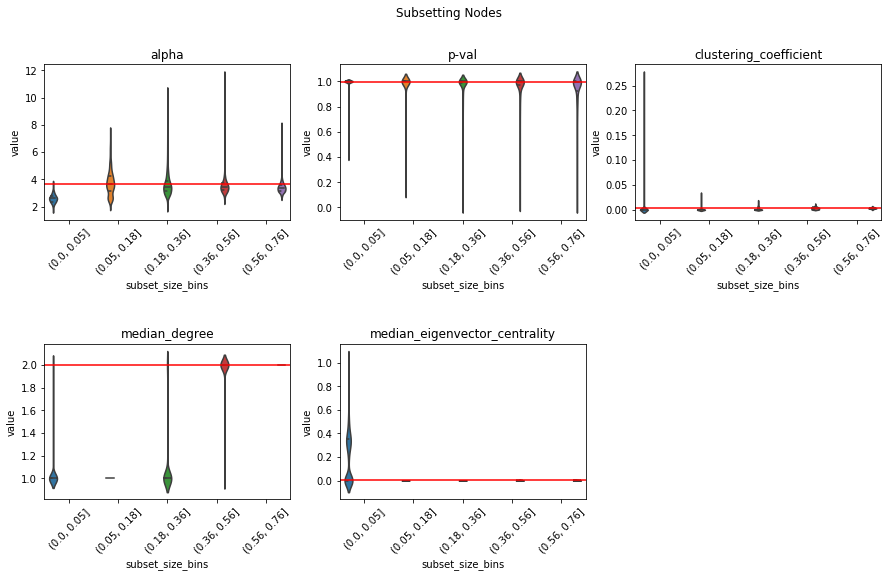

In [47]:
n_col, n_row = 3,2
fig, ax = plt.subplots(figsize = (15,8), ncols = n_col, nrows = n_row)

iterable = res.summary_statistic.unique()
coords = list(itertools.product(range(n_col+1), range(n_row+1)))[:len(iterable)]
counter = 0

for stat in iterable:
    coord = coords[counter]
    res_ = res[res.summary_statistic == stat]
    
    g = sns.violinplot(data = res_, x ='subset_size_bins', y = 'value', hue = 'subset_size_bins', 
                       inner = 'quartile', ax = ax[coord])
    ax[coord].set_title(stat)
    ax[coord].get_legend().remove()
    ax[coord].axhline(y = true_vals[stat], color = 'red')
    for tick in ax[coord].get_xticklabels():
        tick.set_rotation(45)
    counter += 1
    
ax[1,2].axis('off');
fig.suptitle('Subsetting Nodes')

plt.subplots_adjust(wspace=None, hspace=0.8)


# Subset edges

In [23]:
# lazy coding but gets the job done
res = gg.summarize(G).T
for col in ['subset_size']:
    res[col] = float('nan')


n_iter = 1000
n_core = 20
for subset_size in tqdm([0.05,0.2,0.4,0.6,0.8]):
    def get_summary(i):
        try:
            G2 = gg.subset_edges(G, subset_size = subset_size, drop = True)

            summary = gg.summarize(G2).T
            summary['subset_size'] = subset_size
            res_ = list(summary.values[0])
        except:
            res_ = None

        return res_
   
    pool = Pool(processes=n_core) 
    summ = pool.map(get_summary, range(n_iter))
    pool.close()
    
    if summ is not None:
        summary = pd.DataFrame(np.array(summ))
        summary.columns = res.columns
        res = pd.concat([res, summary])
res.to_csv('/data2/hratch/cci_dt/other_analyses/network_subset_properties_edges.csv')

100%|██████████| 5/5 [00:49<00:00,  9.90s/it]


In [36]:
res = pd.read_csv('/data2/hratch/cci_dt/other_analyses/network_subset_properties_edges.csv', index_col = 0)
true_vals = res.iloc[0,:]
res = res.iloc[1:, :]
res = pd.melt(res, id_vars = 'subset_size', var_name = 'summary_statistic')

''

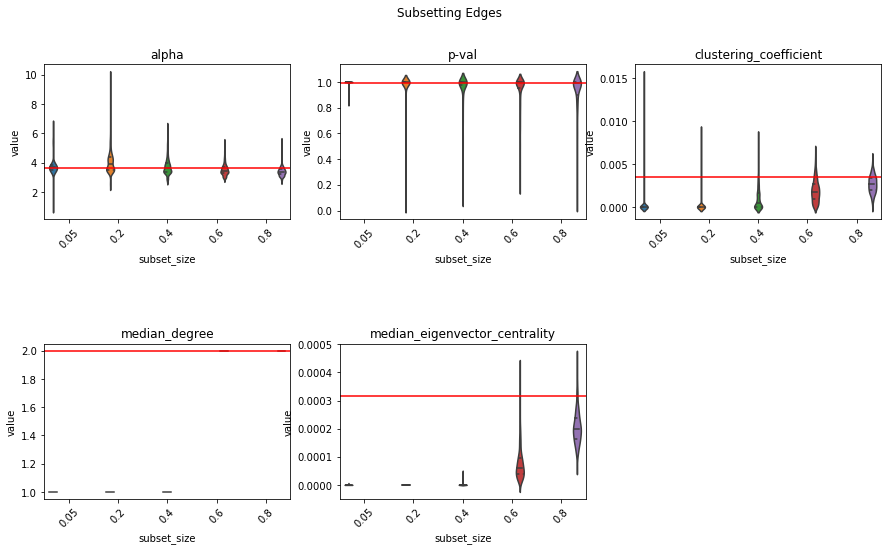

In [42]:
n_col, n_row = 3,2
fig, ax = plt.subplots(figsize = (15,8), ncols = n_col, nrows = n_row)

iterable = res.summary_statistic.unique()
coords = list(itertools.product(range(n_col+1), range(n_row+1)))[:len(iterable)]
counter = 0

for stat in iterable:
    coord = coords[counter]
    res_ = res[res.summary_statistic == stat]
    
    g = sns.violinplot(data = res_, x ='subset_size', y = 'value', hue = 'subset_size', 
                       inner = 'quartile', ax = ax[coord])
    ax[coord].set_title(stat)
    ax[coord].get_legend().remove()
    ax[coord].axhline(y = true_vals[stat], color = 'red')
    for tick in ax[coord].get_xticklabels():
        tick.set_rotation(45)
    counter += 1
    
ax[1,2].axis('off')
fig.suptitle('Subsetting Edges')
plt.subplots_adjust(wspace=None, hspace=0.8)

;